# Credit Card Fraud Detection
- The dataset has been taken from Kaggle website: https://www.kaggle.com/mlg-ulb/creditcardfraud
- The datasets contains transactions made by credit cards in September 2013 by european cardholders.
- Due to confidentiality issues, the dataset contains only numerical input variables which are the result of a PCA transformation. (Principal component analysis)

### Steps performed in this project:
- Exploratory Data Analysis
- Feature Engineering
    - Oversampling to handle imbalanced dataset
- Model Building
    - Random Forest Classifier
    - Logistic Regression
    - Adaboost Classifier
    - K Nearest Neighbours Classifier
    - Isolation Forest
    - Local Outlier Factor
- Model Evaluation
    - Define ROC curve and Optimal Threshold Values
    - Compare all the models
    - Conclusion

## Exploratory Data Analysis

In [1]:
# Import the libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [2]:
# Load the input data file

dataset=pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Features V1, V2, … V28 are the principal components obtained with PCA
- 'Amount' is the transaction Amount
- 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise
- 'Time' contains the seconds elapsed between each transaction and the first transaction

In [3]:
# Check the number of rows and columns in the dataset

dataset.shape

(284807, 31)

In [4]:
# Check missing values

dataset.isnull().values.any()

False

In [5]:
# Check min, max and average values for amount variable

dataset['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [6]:
# Check the count of fraud cases and normal cases

fraud = dataset[dataset['Class']==1]
normal = dataset[dataset['Class']==0]

outlier_fraction = len(fraud)/float(len(normal))
outlier_fraction

0.0017304750013189597

In [7]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


Clearly the dataset is highly imbalanced and need to be handled before applying any machine learning algorithm.

Text(0, 0.5, 'Frequency')

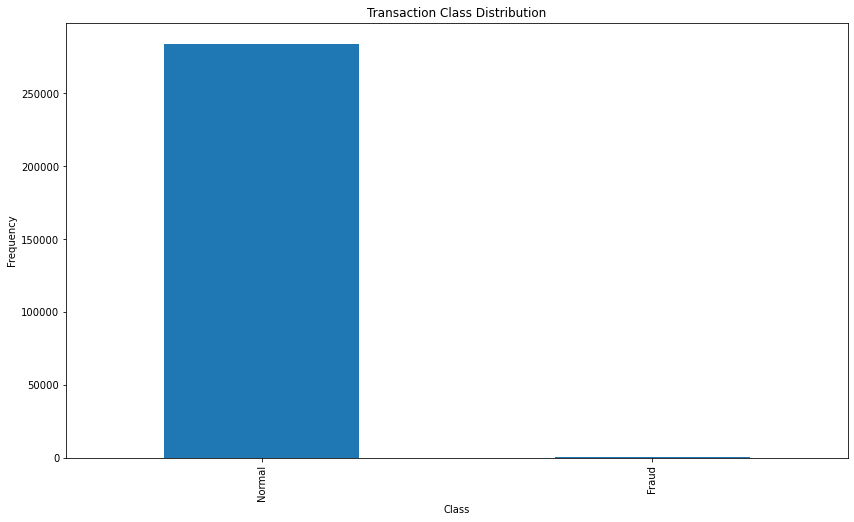

In [8]:
# Visualize the count of fraud and normal cases

LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar')
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

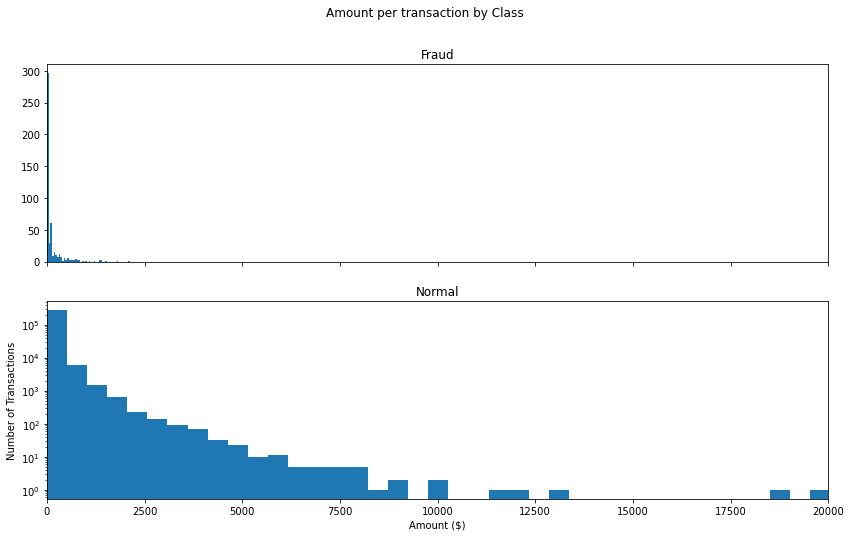

In [9]:
# Check the difference in the amount of money used in different transaction classes

f, (x1, x2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by Class')
x1.hist(fraud.Amount, bins = 50)
x1.set_title('Fraud')
x2.hist(normal.Amount, bins = 50)
x2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

From the above graph it is clear that in case of fraud, smaller amount transactions are done.

Text(0, 0.5, 'Amount')

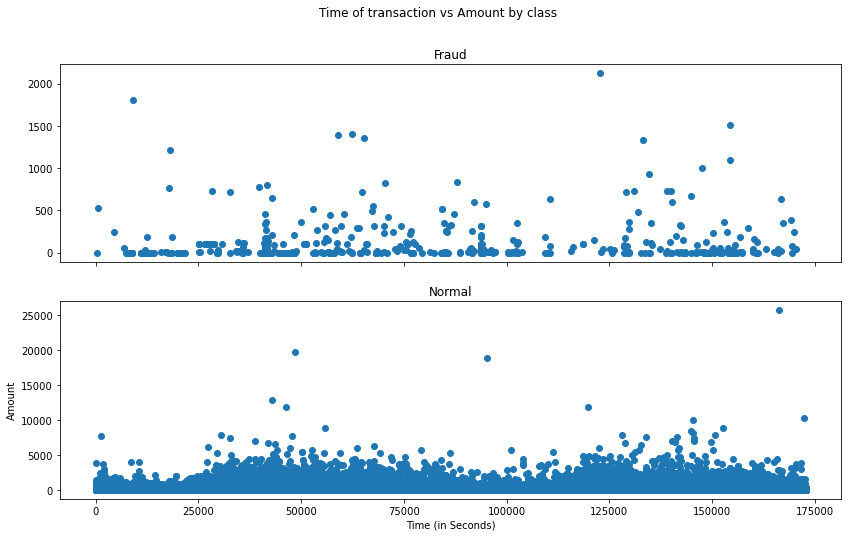

In [10]:
# Check if fraudulent transactions occur more often during certain time frame

f, (x1, x2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
x1.scatter(fraud.Time, fraud.Amount)
x1.set_title('Fraud')
x2.scatter(normal.Time, normal.Amount)
x2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')

From the graph, we can say that there is no noticiable impact of transaction time with fraud.

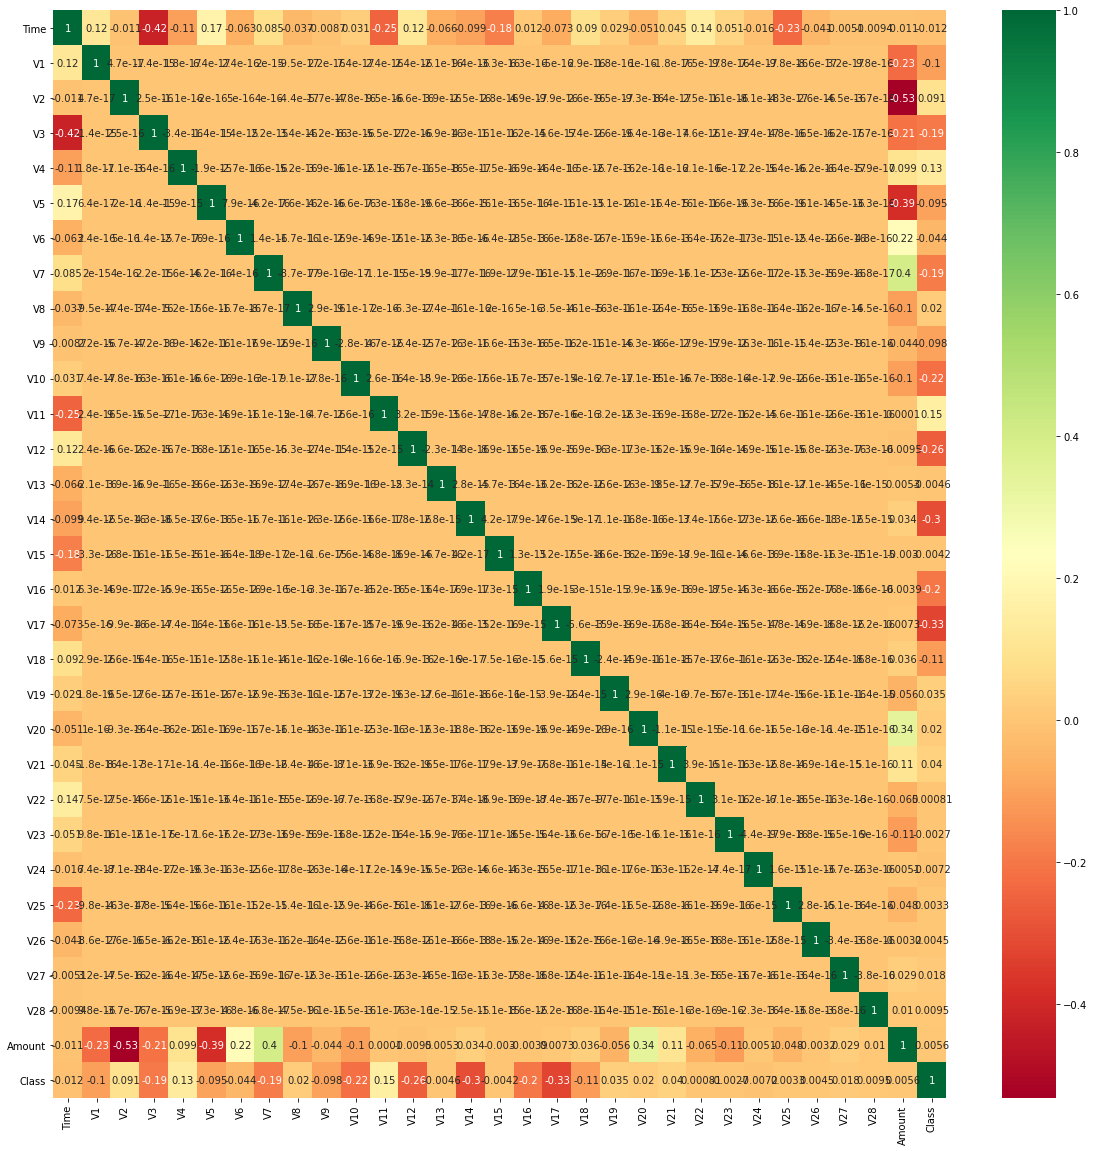

In [11]:
# Check correlation between different variables

plt.figure(figsize=(20,20))
sns.heatmap(dataset.corr(),annot=True,cmap="RdYlGn")

## Feature Engineering

In [12]:
# Create Independent Features list

columns = dataset.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]

In [13]:
# Store the variable we are predicting in target

target = "Class"
X = dataset[columns]
y = dataset[target]

In [14]:
# Print the shapes of X & y

print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


### Oversampling to handle Imbalanced data

In [15]:
# RandomOverSampler to handle imbalanced data

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler()
X_train_res, y_train_res = os.fit_sample(X, y)
X_train_res.shape,y_train_res.shape

((568630, 30), (568630,))

Text(0, 0.5, 'Frequency')

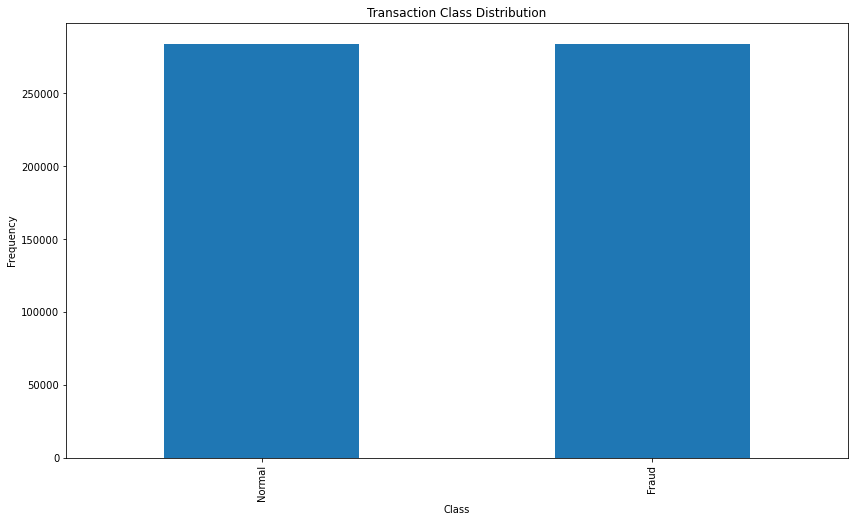

In [16]:
# Visualize the count of fraud and normal cases again

LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(y_train_res, sort = True)
count_classes.plot(kind = 'bar')
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [17]:
print('Original dataset shape {}'.format(Counter(y)))
print('Re-sampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Re-sampled dataset shape Counter({0: 284315, 1: 284315})


## Model Building

In [18]:
# Train test data split

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train_res, y_train_res, test_size=0.3, random_state=42)

# Create lists to store test results of all models
pmodel=[]
n_error=[]
accuracy=[]
fnr=[]
fpr=[]

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

n_errors_rf = (y_pred_rf != y_test).sum()
accuracy_rf = accuracy_score(y_test,y_pred_rf)

print("##### Random Forest Result #####")
print("Error Count :",n_errors_rf)
print("Accuracy Score :", accuracy_rf)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_rf))
print("Classification Report :")
print(classification_report(y_test,y_pred_rf))

fnr_rf=metrics.confusion_matrix(y_test,y_pred_rf)[1,0]
fpr_rf=metrics.confusion_matrix(y_test,y_pred_rf)[0,1]

pmodel.append('RF')
n_error.append(n_errors_rf)
accuracy.append(accuracy_rf)
fnr.append(fnr_rf)
fpr.append(fpr_rf)

##### Random Forest Result #####
Error Count : 7
Accuracy Score : 0.9999589657011883
Confusion Metrics :
[[85142     7]
 [    0 85440]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

n_errors_lr = (y_pred_lr != y_test).sum()
accuracy_lr = accuracy_score(y_test,y_pred_lr)

print("##### Logistic Regression Result #####")
print("Error Count :",n_errors_lr)
print("Accuracy Score :", accuracy_lr)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_lr))
print("Classification Report :")
print(classification_report(y_test,y_pred_lr))

fnr_lr=metrics.confusion_matrix(y_test,y_pred_lr)[1,0]
fpr_lr=metrics.confusion_matrix(y_test,y_pred_lr)[0,1]

pmodel.append('LogR')
n_error.append(n_errors_lr)
accuracy.append(accuracy_lr)
fnr.append(fnr_lr)
fpr.append(fpr_lr)

##### Logistic Regression Result #####
Error Count : 10575
Accuracy Score : 0.9380088985807995
Confusion Metrics :
[[82097  3052]
 [ 7523 77917]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     85149
           1       0.96      0.91      0.94     85440

    accuracy                           0.94    170589
   macro avg       0.94      0.94      0.94    170589
weighted avg       0.94      0.94      0.94    170589



### Adaboost Classifier

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada_classifier = AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)

n_errors_ada = (y_pred_ada != y_test).sum()
accuracy_ada = accuracy_score(y_test,y_pred_ada)

print("##### Adaboost Classifier Result #####")
print("Error Count :",n_errors_ada)
print("Accuracy Score :", accuracy_ada)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_ada))
print("Classification Report :")
print(classification_report(y_test,y_pred_ada))

fnr_ada=metrics.confusion_matrix(y_test,y_pred_ada)[1,0]
fpr_ada=metrics.confusion_matrix(y_test,y_pred_ada)[0,1]

pmodel.append('AdaB')
n_error.append(n_errors_ada)
accuracy.append(accuracy_ada)
fnr.append(fnr_ada)
fpr.append(fpr_ada)

##### Adaboost Classifier Result #####
Error Count : 4718
Accuracy Score : 0.9723428826008711
Confusion Metrics :
[[83535  1614]
 [ 3104 82336]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85149
           1       0.98      0.96      0.97     85440

    accuracy                           0.97    170589
   macro avg       0.97      0.97      0.97    170589
weighted avg       0.97      0.97      0.97    170589



### KNN Classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

n_errors_knn = (y_pred_knn != y_test).sum()
accuracy_knn = accuracy_score(y_test,y_pred_knn)

print("##### KNN Classifier Result #####")
print("Error Count :",n_errors_knn)
print("Accuracy Score :", accuracy_knn)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_knn))
print("Classification Report :")
print(classification_report(y_test,y_pred_knn))

fnr_knn=metrics.confusion_matrix(y_test,y_pred_knn)[1,0]
fpr_knn=metrics.confusion_matrix(y_test,y_pred_knn)[0,1]

pmodel.append('KNN')
n_error.append(n_errors_knn)
accuracy.append(accuracy_knn)
fnr.append(fnr_knn)
fpr.append(fpr_knn)

##### KNN Classifier Result #####
Error Count : 187
Accuracy Score : 0.9989037980174572
Confusion Metrics :
[[84962   187]
 [    0 85440]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



### Isolation Forest Algorithm

- Anomaly Detection Algorithm

     One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.
     

- Benifits

     This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set. Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.
     

- How Isolation Forests Work:

     The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.
     The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.ensemble import IsolationForest

state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

iso_forest=IsolationForest(n_estimators=100, max_samples=len(X_train_res),contamination=outlier_fraction,random_state=state)
iso_forest.fit(X_train, y_train)
y_pred_iso = iso_forest.predict(X_test)

C:\Users\amits\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:285: UserWarning: max_samples (568630) is greater than the total number of samples (199364). max_samples will be set to n_samples for estimation.
  warn("max_samples (%s) is greater than the "


In [25]:
# Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions

y_pred_iso[y_pred_iso == 1] = 0
y_pred_iso[y_pred_iso == -1] = 1

n_errors_iso = (y_pred_iso != y_test).sum()
accuracy_iso = accuracy_score(y_test,y_pred_iso)

print("##### Isolation Forest Result #####")
print("Error Count :",n_errors_iso)
print("Accuracy Score :", accuracy_iso)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_iso))
print("Classification Report :")
print(classification_report(y_test,y_pred_iso))

fnr_iso=metrics.confusion_matrix(y_test,y_pred_iso)[1,0]
fpr_iso=metrics.confusion_matrix(y_test,y_pred_iso)[0,1]

pmodel.append('IsoF')
n_error.append(n_errors_iso)
accuracy.append(accuracy_iso)
fnr.append(fnr_iso)
fpr.append(fpr_iso)

##### Isolation Forest Result #####
Error Count : 178
Accuracy Score : 0.9979167398148473
Confusion Metrics :
[[85217    90]
 [   88    48]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.35      0.35      0.35       136

    accuracy                           1.00     85443
   macro avg       0.67      0.68      0.67     85443
weighted avg       1.00      1.00      1.00     85443



### Local Outlier Factor Algorithm (LOF)

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen:
- greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster
- smaller than the maximum number of close by objects that can potentially be local outliers. 

In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [26]:
from sklearn.neighbors import LocalOutlierFactor

lof=LocalOutlierFactor(n_neighbors=20, algorithm='auto',leaf_size=30, 
                       metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)
y_pred_lof=lof.fit_predict(X_test)

# Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

n_errors_lof = (y_pred_lof != y_test).sum()
accuracy_lof = accuracy_score(y_test,y_pred_lof)

print("##### Local Outlier Factor Result #####")
print("Error Count :",n_errors_lof)
print("Accuracy Score :", accuracy_lof)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_lof))
print("Classification Report :")
print(classification_report(y_test,y_pred_lof))

fnr_lof=metrics.confusion_matrix(y_test,y_pred_lof)[1,0]
fpr_lof=metrics.confusion_matrix(y_test,y_pred_lof)[0,1]

pmodel.append('LOF')
n_error.append(n_errors_lof)
accuracy.append(accuracy_lof)
fnr.append(fnr_lof)
fpr.append(fpr_lof)

##### Local Outlier Factor Result #####
Error Count : 282
Accuracy Score : 0.9966995540886907
Confusion Metrics :
[[85160   147]
 [  135     1]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.01      0.01      0.01       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



## Model Evaluation

### Define ROC Curve and Optimal Threshold Value

In [27]:
# Now we will focus on selecting the best threshold for checking if accuracy can be 
# futher increased by creating an ensemble model

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train_res, y_train_res, test_size=0.3, random_state=42)

pred=[]
for models in [rf_model,log_reg,ada_classifier,knn_classifier]:
    pred.append(pd.Series(models.predict_proba(X_test)[:,1]))
    
final_prediction=pd.concat(pred,axis=1).mean(axis=1)

print('Ensemble Test ROC-AUC: {}'.format(roc_auc_score(y_test,final_prediction)))

Ensemble Test ROC-AUC: 0.9999999481796242


In [28]:
pd.concat(pred,axis=1)

,0,1,2,3
0,1.0,0.999319,0.546865,1.0
1,1.0,1.000000,0.553611,1.0
2,0.0,0.206832,0.470932,0.0
3,1.0,1.000000,0.546800,1.0
4,1.0,1.000000,0.543423,1.0
...,...,...,...,...
170584,0.0,0.179809,0.476564,0.0
170585,0.0,0.759441,0.473921,0.0
170586,1.0,0.033318,0.500407,1.0
170587,1.0,1.000000,0.546145,1.0


In [29]:
# Calculate the ROC Curve

fpr_c, tpr_c, thresholds = roc_curve(y_test, final_prediction)

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
435,0.411270,0.999607
436,0.409567,0.999601
437,0.388973,0.999384
438,0.388526,0.999379
434,0.633431,0.998910


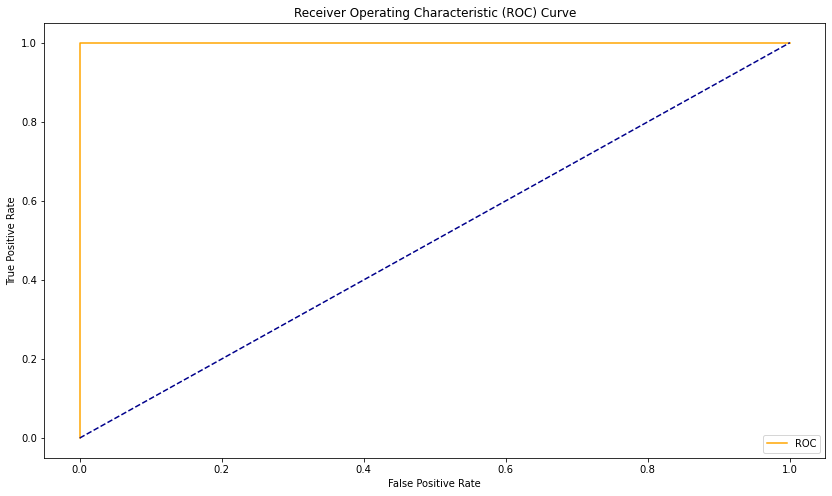

In [30]:
def plot_roc_curve(fpr_c, tpr_c):
    plt.plot(fpr_c, tpr_c, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
plot_roc_curve(fpr_c,tpr_c)

### Compare all the Models

In [31]:
n_error

[7, 10575, 4718, 187, 178, 282]

In [32]:
accuracy

[0.9999589657011883,
 0.9380088985807995,
 0.9723428826008711,
 0.9989037980174572,
 0.9979167398148473,
 0.9966995540886907]

In [33]:
pmodel

['RF', 'LogR', 'AdaB', 'KNN', 'IsoF', 'LOF']

In [34]:
fpr

[7, 3052, 1614, 187, 90, 147]

In [35]:
fnr

[0, 7523, 3104, 0, 88, 135]

Text(0, 0.5, 'Error Count')

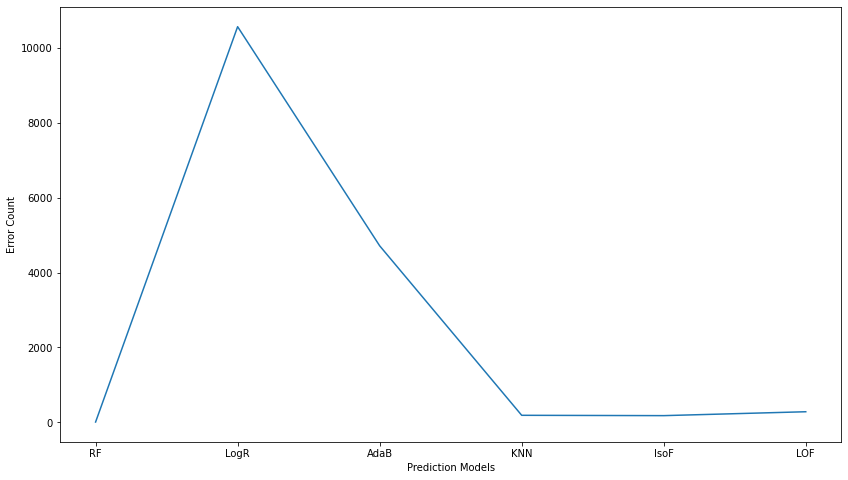

In [36]:
plt.plot(pmodel,n_error)
plt.xlabel('Prediction Models')
plt.ylabel('Error Count')

Text(0, 0.5, 'Accuracy Rate')

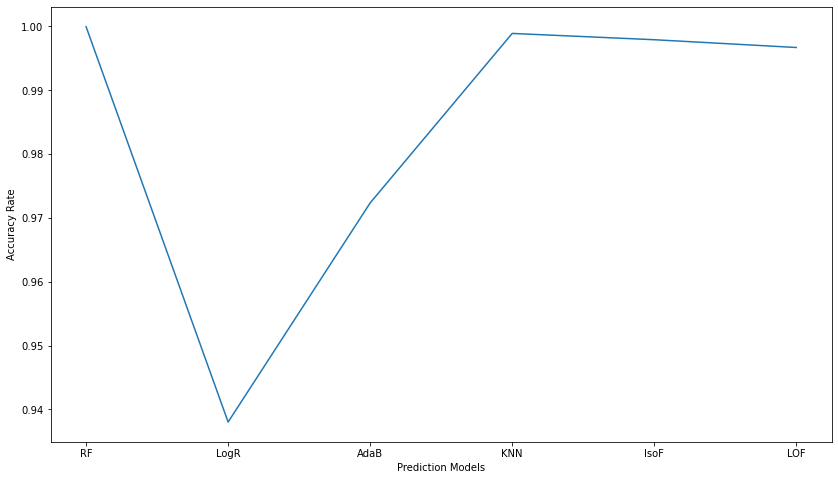

In [37]:
plt.plot(pmodel, accuracy)
plt.xlabel('Prediction Models')
plt.ylabel('Accuracy Rate')

Text(0, 0.5, 'False Positive Rate')

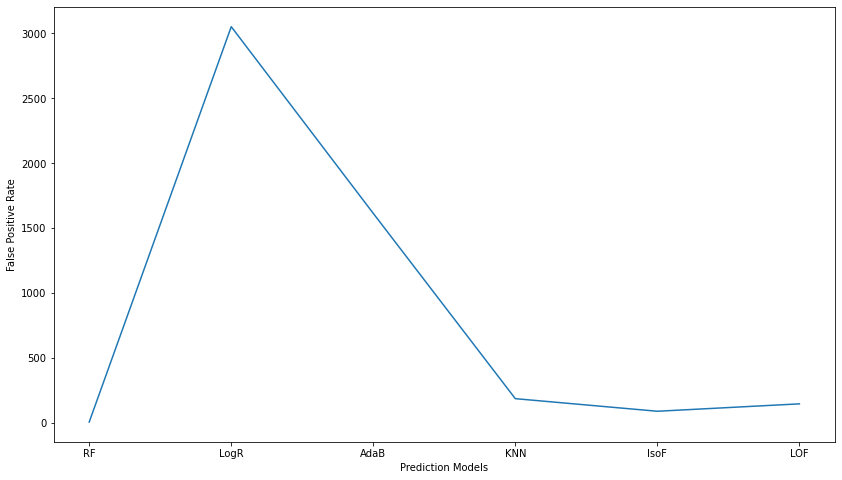

In [38]:
plt.plot(pmodel,fpr)
plt.xlabel('Prediction Models')
plt.ylabel('False Positive Rate')

Text(0, 0.5, 'False Negative Rate')

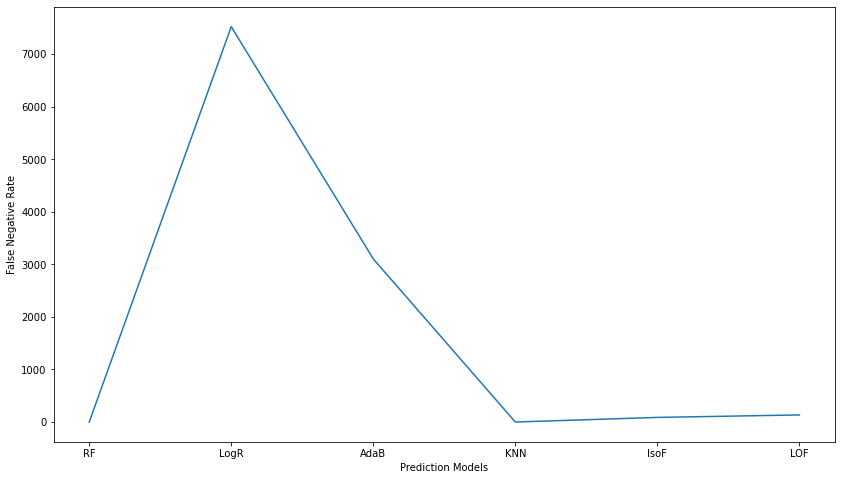

In [39]:
plt.plot(pmodel,fnr)
plt.xlabel('Prediction Models')
plt.ylabel('False Negative Rate')

### Conclusion

- Both Random forest and KNN algorithm gives very good result with high accuracy rate and low error count
- Logistic Regression works worst in predicting the fraud.
- Random Forest gives highest accuracy rate of 99.99% with just 7 errors.
- From Confusion Metrics Results, False Negative Rate is 0 in both KNN and Random Forest. This is a desired result, as we want minimum number of transactions which are actually fraudulent but detected as normal.
- By creating an ensemble model, maximum accuarcy of 99.96% was achieved at a threshold value of 0.411
- Overall, Random Forest works best in this case.